# [프로젝트3] Prophet 모델로 이상치 탐지하기

---

## 프로젝트 목표
---

Prophet 모델을 사용하여 MME 장비의 이상치 탐지


## 프로젝트 목차
---
<div class="toc"><ul class="toc-item"><li><span><a href="#프로젝트-목차" data-toc-modified-id="프로젝트-목차-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>프로젝트 목차</a></span></li><li><span><a href="#프로젝트-개요" data-toc-modified-id="프로젝트-개요-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>프로젝트 개요</a></span></li><li><span><a href="#1.-데이터-읽기" data-toc-modified-id="1.-데이터-읽기-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>1. 데이터 읽기</a></span><ul class="toc-item"><li><span><a href="#라이브러리-불러오기" data-toc-modified-id="라이브러리-불러오기-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>라이브러리 불러오기</a></span></li><li><span><a href="#데이터-불러오기" data-toc-modified-id="데이터-불러오기-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>데이터 불러오기</a></span></li></ul></li><li><span><a href="#Prophet-모델-학습" data-toc-modified-id="Prophet-모델-학습-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Prophet 모델 학습</a></span><ul class="toc-item"><li><span><a href="#분해법" data-toc-modified-id="분해법-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>분해법</a></span></li></ul></li><li><span><a href="#이상치-탐지" data-toc-modified-id="이상치-탐지-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>이상치 탐지</a></span><ul class="toc-item"><li><span><a href="#임계값-설정" data-toc-modified-id="임계값-설정-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>임계값 설정</a></span></li><li><span><a href="#그래프-그리기" data-toc-modified-id="그래프-그리기-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>그래프 그리기</a></span></li></ul></li></ul></div>

## 프로젝트 개요

---

앞서 ARIMA 모델로 이상치 탐지를 해보았습니다.
이번 시간에는 ARIMA 보다 조금 더 정확한 트렌드 예측 분석을 제공하는 라이브러리 'Facebook Prophet'을 사용하여 이상치 탐지를 해보도록합니다. 

> prophet은 addictive 모형에 기반한 시계열 예측 모델로서 시계열 데이터의 트렌드성 (연간/월간/ 일간) 을 예측하는 것에 초점이 맞춰져잇습니다. 
Additive모델은 선형 회귀분석의 단점을 극복하기 위해 개량된 분석방법의 하나입니다.

## 데이터 읽기

---

### 라이브러리 불러오기
---

본 프로젝트에 필요한 라이브러리를 불러옵니다.

In [1]:
import pickle
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from prophet import Prophet

warnings.filterwarnings(action="ignore")  # warning ignore

pd.options.display.max_rows = 80
pd.options.display.max_columns = 80
sns.set_style("whitegrid")

%matplotlib inline

/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 데이터 불러오기
---

프로젝트 1에서 전처리가 끝난 데이터(`MME_data.p`) 를 불러옵니다. 또한 기기별로 이상치 탐지를 하기 위하여 기기 정보를 devices로 저장해 놓도록 합니다. 

In [2]:
# load 
with open('MME_data.p', 'rb') as fp:
    total_df = pickle.load(fp)

In [3]:
# 데이터를 쉽게 불러오기 위하여 기기를 정의
devices = [
    "MME017",
    "MME018",
    "MME071",
    "MME072",
    "MME073",
    "MME074",
    "MME091",
    "MME092",
    "MME093",
]

## Prophet 모델 학습

### [TODO]  Prophet 모델을 사용하여 시계열 예측하기
앞서 불러온 데이터를 Prophet모델에 학습시켜보겠습니다.

- Prophet모델의 weekly_seasonality는 True, yearly_seasonality는 False로 설정합니다.

In [4]:
# 데이터 한 개 선택 
device_df = total_df[devices[0]] 

# 데이터 중 하나의 컬럼 선택 
device_df = device_df['comb_tau_succ_rate']

# 훈련 데이터를 70%, 테스트 데이터를 30%로 분리합니다.
train_size = int(len(device_df) * 0.7)

train_df = device_df.iloc[:train_size]
test_df = device_df.iloc[train_size:]

In [41]:
def fit_predict_model(train_df, test_df):
    """
        Summary: prophet 모델을 사용하여 시계열을 예측하도록합니다. 
    Args: 
        dataframe
    """
    def _reformat_df(df):
        df = df.reset_index()
        df.columns = ["ds", "y"]  # prophet 데이터는 컬럼이 'ds','y'만을 받습니다.

        return df

    train_df, test_df = map(_reformat_df, [train_df, test_df])
    
    m = Prophet(
        daily_seasonality=True,
        weekly_seasonality=False,
        yearly_seasonality=False
        ) 
    # 일간 계절성이 있습니다. 
    m = m.fit(train_df)

    forecast = m.predict(test_df.loc[:, ["ds"]])
    forecast["real"] = test_df["y"].reset_index(drop=True)
    
    return forecast, m

In [42]:
forecast, m = fit_predict_model(train_df, test_df)

06:18:48 - cmdstanpy - INFO - Chain [1] start processing
06:18:49 - cmdstanpy - INFO - Chain [1] done processing


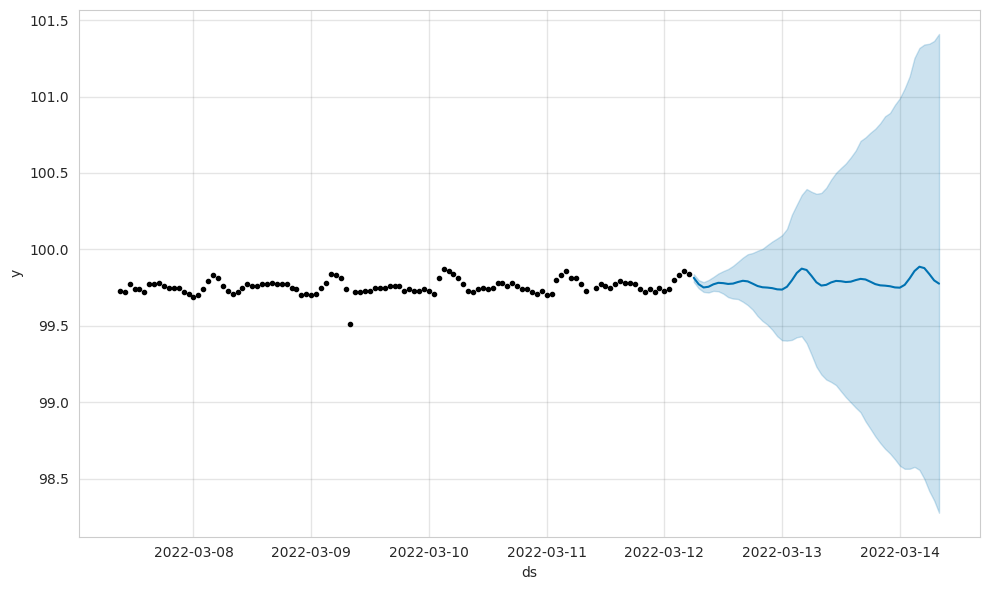

In [43]:
fig1 = m.plot(forecast)

### 분해법 

prophet모델을 가지고 주어진 시계열을 분해(decomposition) 해봅니다. 

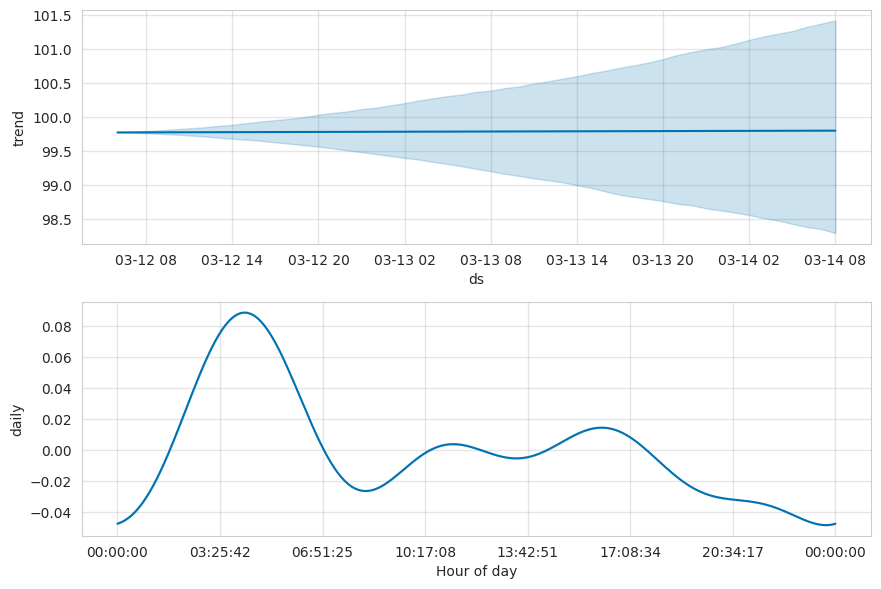

In [44]:
fig = m.plot_components(forecast)

## 이상치 탐지 

Prophet 모델로 학습된 모델을 사용하여 이상치를 탐지해보도록 합니다. 

### 임계값 설정

### [TODO]  Prophet모델 활용하여 이상치 판단하기
Prophet 모델은 상한(upper bound)와 하한(lower bound)를 제공합니다. 이에 상한과 하한을 넘는 데이터는 이상치라 판단하도록 합니다.
- anomaly열에는 정상치는 0을, 상한을 넘는 데이터는 1을, 하한을 넘는 데이터에는 -1을 저장합니다.

In [45]:
def detect_anomalies(forecast):
    forecasted = forecast[
        ["ds", "trend", "yhat", "yhat_lower", "yhat_upper", "real"]
    ].copy()

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['real']>forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['real']<forecasted['yhat_lower'], 'anomaly']= -1

    # anomaly importances
    forecasted["importance"] = 0
    
    forecasted.loc[forecasted["anomaly"] == 1, "importance"] = (
        forecasted["real"] - forecasted["yhat_upper"]
    ) / forecast["real"]

    forecasted.loc[forecasted["anomaly"] == -1, "importance"] = (
        forecasted["yhat_lower"] - forecasted["real"]
    ) / forecast["real"]

    return forecasted

In [46]:
pred = detect_anomalies(forecast)
pred.head()

,ds,trend,yhat,yhat_lower,yhat_upper,real,anomaly,importance
0,2022-03-12 06:00:00,99.774733,99.813809,99.787221,99.836911,99.80,0,0.000000
1,2022-03-12 07:00:00,99.775255,99.771794,99.744887,99.798329,99.76,0,0.000000
2,2022-03-12 08:00:00,99.775776,99.750549,99.721508,99.785153,99.70,-1,0.000216
3,2022-03-12 09:00:00,99.776298,99.755101,99.717489,99.799310,99.71,-1,0.000075
4,2022-03-12 10:00:00,99.776819,99.771163,99.728253,99.819503,99.72,-1,0.000083


### 그래프 그리기 

최종 예측값을 그래프로 표현합니다.

In [47]:
def dependency_plot(pred):
    total_indices = list(range(len(pred)))
    total_values = pred["real"].values

    abnormal_indices = pred[pred["anomaly"] != 0].index.values
    abnormal_values = pred[pred["anomaly"] != 0]["real"].values

    # 그림 그리기
    plt.plot(total_indices, total_values, color="green")
    plt.scatter(abnormal_indices, abnormal_values, color="r")
    plt.show()

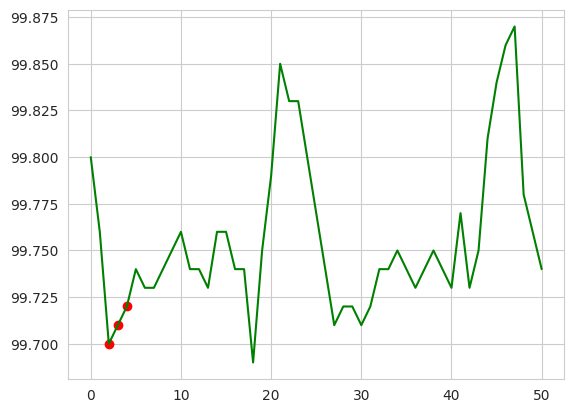

In [48]:
# plot_anomalies(pred)
dependency_plot(pred)